# Local Interpretability

In [ ]:
#default_exp core

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#exporti
from fastai.vision import *
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gif
import numpy as np

In [ ]:
#exporti
def dice_by_component(predictedMask, trueMask, component = 1):
    dice = 1
    pred = predictedMask.data == component
    msk = trueMask.data == component
    intersect = pred&msk
    total = pred.sum() + msk.sum() 
    if total > 0:
        dice = 2 * intersect.sum().float() / total
    return dice.item()

## Sensitivity Analysis

### Example data (kaggle)

In [ ]:
img = lambda: open_image("example/kaggle/images/1-frame014-slice005.png")
trueMask = lambda: open_mask("example/kaggle/masks/1-frame014-slice005.png")
trainedModel = load_learner(path="example/kaggle", file="model.pkl", tfm_y=False)

### Generic functions

In [ ]:
#export
def plot_generic_series(image, model, transform_function, start=0, end=180, num=5, param_name='param', log_steps=False):
    fig, axs = plt.subplots(1,num,figsize=(16,6))
    steps = np.linspace(start,end,num)
    if log_steps:
        steps = np.exp(np.linspace(log(start),log(end),num))
    for param, ax in zip(steps, axs.flatten()):
        img = image.clone()
        img = transform_function(img, param)
        img.show(ax=ax, title=f'{param_name}={param:.2f}', y =  model.predict(img)[0])

### Rotation

In [ ]:
#export
def plot_rotation_series(image, model, start=0, end=180, num=6):
    rotationTransform = lambda image, deg: image.resize(256).rotate(degrees=int(deg))
    plot_generic_series(image,model,rotationTransform, start=start, end=end, num=num, param_name="degrees")

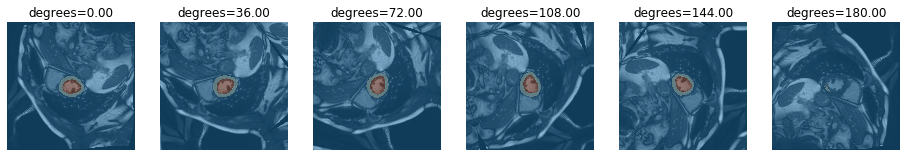

In [ ]:
plot_rotation_series(img(), trainedModel)

In [ ]:
#export
def rotation_series(image_function, mask_function, model, step_size=5):
    trueMask = mask_function().resize(256)
    results = list()
    for deg in tqdm(range(0, 360, step_size)):
        image = image_function().resize(256)
        rotatedImage = image.rotate(degrees=deg)
        prediction = model.predict(rotatedImage)[0]
        prediction._px = prediction._px.float()
        rotatedPrediction = prediction.rotate(degrees=-deg)
        diceLV = dice_by_component(rotatedPrediction, trueMask, component = 1)
        diceMY = dice_by_component(rotatedPrediction, trueMask, component = 2)
        results.append([deg, diceLV, diceMY])

    results = pd.DataFrame(results,columns = ['deg', 'diceLV', 'diceMY'])
    return results

[0, 360, 0, 1]

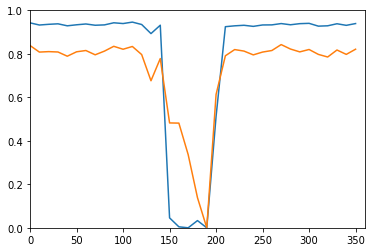

In [ ]:
results = rotation_series(img, trueMask, trainedModel, step_size=10)
plt.plot(results['deg'], results['diceLV'])
plt.plot(results['deg'], results['diceMY'])
plt.axis([0,360,0,1])

In [ ]:
#export
@gif.frame
def plot_rotation(image_function, model, deg=90):
    img = image_function().resize(256).rotate(degrees=int(deg))
    return img.show(title=f'degrees={deg}', y =  model.predict(img)[0])

You can easily generate gifs by plotting multiple frames

In [ ]:
frames = [plot_rotation(img,trainedModel,x) for x in tqdm(range(0,360,5))]

In [ ]:
gif.save(frames, "example/kaggle/rotation.gif", duration=150)

![segmentation sensitivity to rotation](example/kaggle/rotation.gif)

### Cropping

In [ ]:
#export
def cropTransform(image, pxls):
    image.resize(256)
    image.crop(int(pxls))
    image.rotate(180)
    image.crop_pad(256,padding_mode='zeros')
    image.rotate(180)
    return image

def plot_crop_series(image, model, start=256, end=56, num=5):
    plot_generic_series(image,model,cropTransform, start=start, end=end, num=num, param_name="pixels")

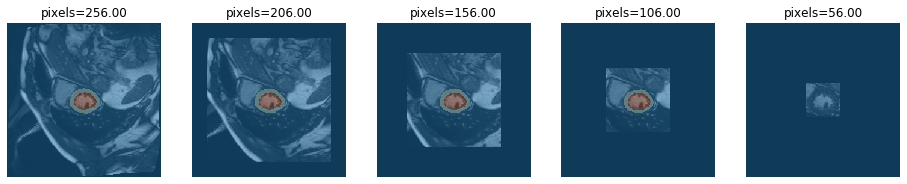

In [ ]:
plot_crop_series(img(), trainedModel)

In [ ]:
#export
def crop_series(image_function, mask_function, model, step_size=5):
    results = list()
    for pxls in tqdm(range(256, 32, -step_size)):
        image = image_function()
        image.resize(256)
        trueMask = mask_function()
        trueMask.resize(256)

        # use double rotation to avoid cropping and padding with odd numbers to lead to 1px offset
        croppedImage = image.crop(pxls).rotate(180).crop_pad(256, padding_mode = 'zeros').rotate(180)
        prediction = model.predict(croppedImage)[0]
        prediction._px = prediction._px.float()

        diceLV = dice_by_component(prediction, trueMask, component = 1)
        diceMY = dice_by_component(prediction, trueMask, component = 2)
        results.append([pxls, diceLV, diceMY])

    results = pd.DataFrame(results,columns = ['pxls', 'diceLV', 'diceMY'])
    return results

[0, 256, 0, 1]

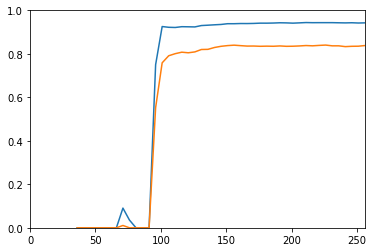

In [ ]:
results = crop_series(img, trueMask, trainedModel, step_size=5)
plt.plot(results['pxls'], results['diceLV'])
plt.plot(results['pxls'], results['diceMY'])
plt.axis([0,256,0,1])

In [ ]:
#export
@gif.frame
def plot_crop(image_function, model, pxls, **kwargs):
    img = image_function().resize(256).crop(pxls).rotate(180).crop_pad(256, padding_mode = 'zeros').rotate(180)
    return img.show(title=f'cropping={pxls}', y =  model.predict(img)[0], **kwargs)

In [ ]:
frames1 = [plot_crop(img,trainedModel,x) for x in tqdm(range(256,32,-5))]

In [ ]:
gif.save(frames1, "example/kaggle/crop.gif", duration=150)

![segmentation sensitivity to cropping](example/kaggle/crop.gif)

### Brightness

In [ ]:
#export
def plot_brightness_series(image, model, start=0.05, end=0.95, num=5):
    brightnessTransform = lambda image, light: image.resize(256).brightness(light)
    plot_generic_series(image,model,brightnessTransform, start=start, end=end, num=num, param_name="brightness")

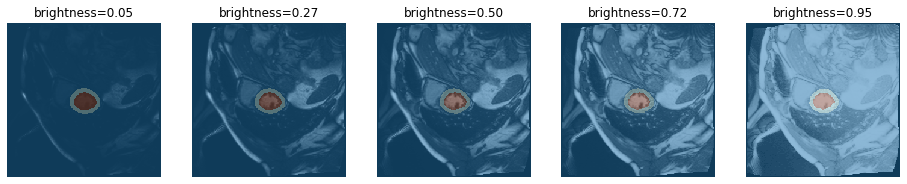

In [ ]:
plot_brightness_series(img(), trainedModel)

In [ ]:
#export
def bright_series(image_function, mask_function, model, step_size=0.05):
    trueMask = mask_function().resize(256)
    results1 = list()
    for light in tqdm(np.arange(0, 1.05, step_size)):
        image = image_function()
        image.resize(256)
        BrightImage = brightness(image, light)
        prediction = model.predict(BrightImage)[0]
        prediction._px = prediction._px.float()
        
        diceLV1 = dice_by_component(prediction, trueMask, component = 1)
        diceMY1 = dice_by_component(prediction, trueMask, component = 2)
        results1.append([light, diceLV1, diceMY1])
        
    results1 = pd.DataFrame(results1,columns = ['light', 'diceLV1', 'diceMY1'])
    return results1

[0, 1, 0, 1]

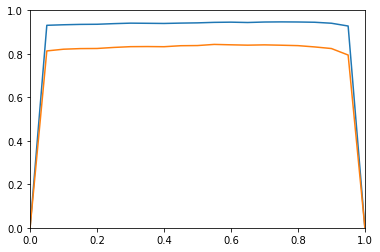

In [ ]:
results = bright_series(img, trueMask, trainedModel, step_size=0.05)
plt.plot(results['light'], results['diceLV1'])
plt.plot(results['light'], results['diceMY1'])
plt.axis([0,1,0,1])

In [ ]:
#export
@gif.frame
def plot_brightness(image_function, model, light):
    img = image_function().resize(256).brightness(light)    
    return img.show(title=f'brightness={light}', y =  model.predict(img)[0])

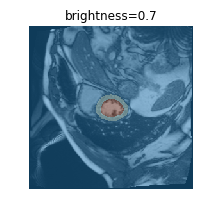

In [ ]:
plot_brightness(img, trainedModel, 0.7)

In [ ]:
frames4 = [plot_brightness(img,trainedModel,x) for x in tqdm(np.arange(0.0, 1.0, 0.05))]

In [ ]:
gif.save(frames4, "example/kaggle/brightness.gif", duration=150)

![segmentation sensitivity to brightness](example/kaggle/brightness.gif)

### Contrast

In [ ]:
#export
def plot_contrast_series(image, model, start=0.1, end=7, num=5):
    contrastTransform = lambda image, scale: image.resize(256).contrast(scale)
    plot_generic_series(image,model,contrastTransform, start=start, end=end, num=num, param_name="scale", log_steps=True)

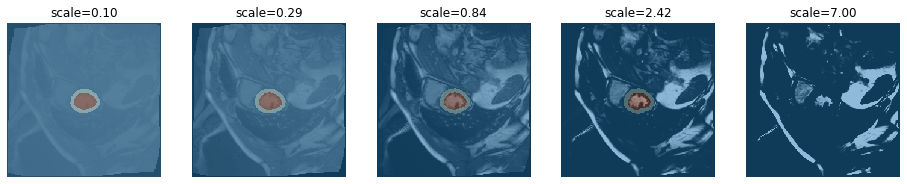

In [ ]:
plot_contrast_series(img(), trainedModel)

In [ ]:
#export
def contrast_series(image_function, mask_function, model, step_size=0.5):
    trueMask = mask_function().resize(256)
    results1 = list()
    for scale in tqdm(np.arange(0, 7, step_size)):
        image = image_function()
        image.resize(256)
        ContrastImage = contrast(image, scale)
        prediction = model.predict(ContrastImage)[0]
        prediction._px = prediction._px.float()
        
        diceLV1 = dice_by_component(prediction, trueMask, component = 1)
        diceMY1 = dice_by_component(prediction, trueMask, component = 2)
        results1.append([scale, diceLV1, diceMY1])
        
    results1 = pd.DataFrame(results1,columns = ['scale', 'diceLV1', 'diceMY1'])
    return results1

[0, 7, 0, 1]

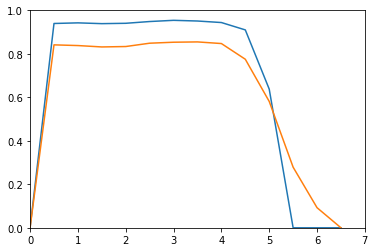

In [ ]:
results = contrast_series(img, trueMask, trainedModel, step_size=.5)
plt.plot(results['scale'], results['diceLV1'])
plt.plot(results['scale'], results['diceMY1'])
plt.axis([0,7,0,1])

In [ ]:
#export
@gif.frame
def plot_contrast(image_function, model, scale):
    img = image_function().resize(256).contrast(scale=scale)    
    return img.show(title=f'contrast={scale}', y =  model.predict(img)[0])

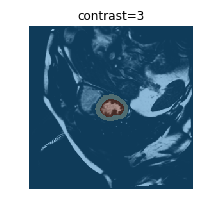

In [ ]:
plot_contrast(img, trainedModel, 3)

In [ ]:
frames3 = [plot_contrast(img,trainedModel,x)for x in tqdm(np.arange(0.0, 7.0, 0.5))]

In [ ]:
gif.save(frames3, "example/kaggle/contrast.gif", duration=150)

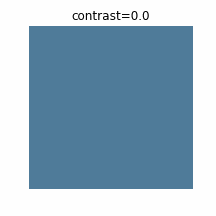

In [ ]:
from IPython.display import Image
Image("example/kaggle/contrast.gif")

![segmentation sensitivity to contrast](example/kaggle/contrast.gif)

### Zoom

In [ ]:
#export
def plot_zoom_series(image, model, start=1.00, end=2.75, num=5):
    zoomTransform = lambda image, scale1: image.resize(256).zoom(scale1)
    plot_generic_series(image,model,zoomTransform, start=start, end=end, num=num, param_name="scale1")

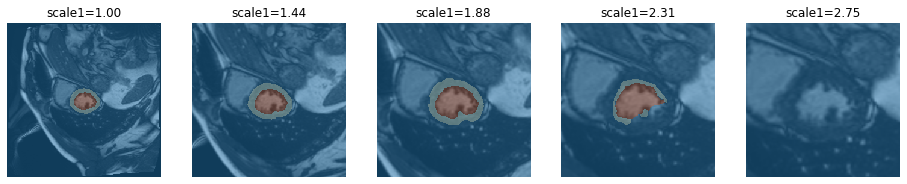

In [ ]:
plot_zoom_series(img(), trainedModel)

In [ ]:
#export
def zoom_series(image_function, mask_function, model, step_size=0.75):
    results = list()
    for scale1 in tqdm(np.arange(1., 3.0, step_size)):
        trueMask = mask_function().resize(256)
        trueMask.zoom(scale = scale1)
        image = image_function()
        image.resize(256)
        zoomImage = image.zoom(scale = scale1)
        prediction = model.predict(zoomImage)[0]
        prediction._px = prediction._px.float()
                
        diceLV = dice_by_component(prediction, trueMask, component = 1)
        diceMY = dice_by_component(prediction, trueMask, component = 2)
        results.append([scale1, diceLV, diceMY])
        
    results = pd.DataFrame(results,columns = ['scale1', 'diceLV', 'diceMY'])
    return results
        

[1, 3, 0, 1]

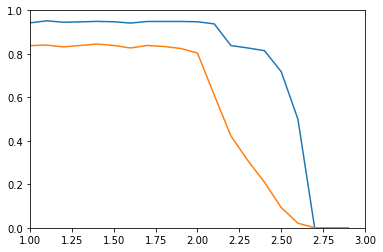

In [ ]:
results = zoom_series(img, trueMask, trainedModel, step_size=.1)
plt.plot(results['scale1'], results['diceLV'])
plt.plot(results['scale1'], results['diceMY'])
plt.axis([1,3,0,1])

In [ ]:
#export
@gif.frame
def plot_zoom(image_function, model, scale, **kwargs):
    
    img = image_function().resize(256).zoom(scale = scale)
    return img.show(title=f'zoom={scale}', y =  model.predict(img)[0], **kwargs)

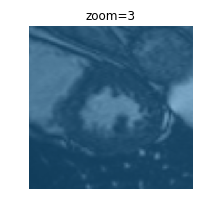

In [ ]:
plot_zoom(img, trainedModel, 3)

In [ ]:
frames2 = [plot_zoom(img,trainedModel,x)for x in tqdm(np.arange(1.0, 3.0, 0.1))]

In [ ]:
gif.save(frames2, "example/kaggle/zoom.gif", duration=150)

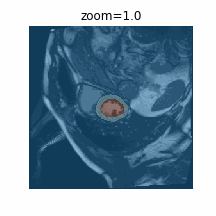

In [ ]:
from IPython.display import Image
Image("example/kaggle/zoom.gif")

![segmentation sensitivity to zoom](example/kaggle/zoom.gif)

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_local_interpret.ipynb.
Converted index.ipynb.
